In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [5]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20250425/ACME/04_25_2025_15:31:25_full_ACME.parquet"
)

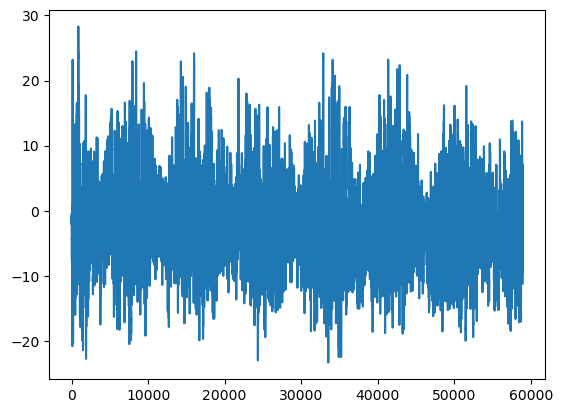

In [6]:
plt.plot(df["target_error"])

In [51]:
# ldf = pd.DataFrame()
# for i in np.arange(9, 10):
#     model_path_LSTM = f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/hrrr_prospectus/LOUI/LOUI_fh{i}_tp_HRRR_ml_output_linear.parquet"

#     # Read parquet file
#     ldf_ = pd.read_parquet(model_path_LSTM)

#     # Concatenate with the main DataFrame
#     ldf = pd.concat([ldf_, ldf], ignore_index=True)
#     print(ldf.shape)

# # Sort by valid_time
# ldf = ldf.sort_values(by="valid_time").reset_index(drop=True)

In [52]:
ldf = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20250424/ACME/ACME_fh1_t2m_HRRR_ml_output_og.parquet"
)
for c in ldf.columns:
    if c != "valid_time":
        ldf[c] = ldf[c] / 3000
ldf

,target_error,Model forecast,diff,valid_time
24,-4.390794,-1.133214,-3.257579,2018-01-01 01:00:00
25,-4.599708,-1.133512,-3.466196,2018-01-01 02:00:00
26,-4.591378,-1.133310,-3.458068,2018-01-01 03:00:00
27,-4.461306,-1.133162,-3.328145,2018-01-01 04:00:00
28,-4.691822,-1.132295,-3.559527,2018-01-01 05:00:00
...,...,...,...,...
58928,-2.978416,-0.408147,-2.570268,2024-12-30 18:00:00
58929,-3.626984,-0.340137,-3.286847,2024-12-30 19:00:00
58930,-4.491337,-0.274797,-4.216540,2024-12-30 20:00:00
58931,-4.503596,-0.219772,-4.283825,2024-12-30 21:00:00


(-15.0, 15.0)

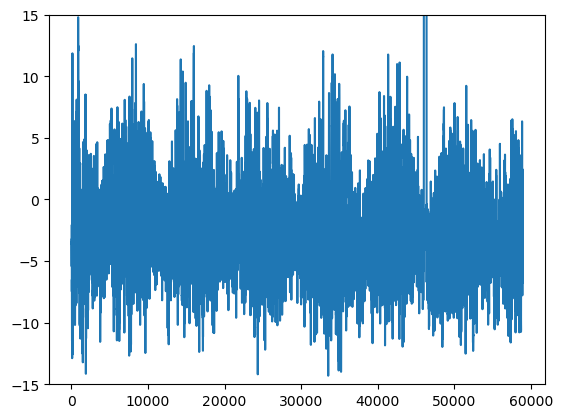

In [53]:
plt.plot(ldf["diff"])
plt.ylim(-15, 15)

In [54]:
import sys

sys.path.append("..")

from src.data import nysm_data
from src.data import gfs_data
from src.data import nam_data

In [55]:
nysm_df = nysm_data.load_nysm_data(gfs=False)
# nysm_df = nysm_df.rename(columns={'time_1H':'valid_time'})
# gfs_df = gfs_data.read_gfs_data('012')
station = "Deleware"

In [56]:
# nysm_df

In [57]:
ldf.dropna(inplace=True)
ldf.head()

,target_error,Model forecast,diff,valid_time
24,-4.390794,-1.133214,-3.257579,2018-01-01 01:00:00
25,-4.599708,-1.133512,-3.466196,2018-01-01 02:00:00
26,-4.591378,-1.133310,-3.458068,2018-01-01 03:00:00
27,-4.461306,-1.133162,-3.328145,2018-01-01 04:00:00
28,-4.691822,-1.132295,-3.559527,2018-01-01 05:00:00


In [58]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            f = int(len(df_test) * 0.5)
            df_val = df_test.iloc[:f]
            df_test = df_test[-f:]

    return df_train["valid_time"], df_test["valid_time"], df_val["valid_time"]

In [59]:
# ldf["valid_time"] = pd.to_datetime(ldf["valid_time"])

In [60]:
df_train, df_test, df_val = which_fold(ldf, 4)

In [61]:
test_set_start = df_test.iloc[0]
test_set_start

Timestamp('2024-04-28 10:00:00')

In [62]:
test_set_finish = df_test.iloc[-1]
test_set_finish

Timestamp('2024-12-30 22:00:00')

In [63]:
df_val.iloc[0]

Timestamp('2023-08-20 14:00:00')

In [64]:
df_val.iloc[-1]

Timestamp('2024-04-28 09:00:00')

In [65]:
def date_filter(ldf, time1, time2):
    ldf = ldf[ldf["valid_time"] > time1]
    ldf = ldf[ldf["valid_time"] < time2]

    return ldf

In [66]:
def met_output(df, station, fh):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df[f"u_total_{station}"]),
        c="mediumseagreen",
        linewidth=3,
        label="NAM Prediction",
    )

    plt.plot(
        np.array(x),
        np.array(df["reforecast"]),
        c="red",
        linewidth=3,
        linestyle="--",  # Dashed line
        label="LSTM Reforecast",
    )

    plt.plot(
        np.array(x),
        np.array(df[f"wspd_sonic_mean_{station}"]),
        c="black",
        linewidth=1,
        alpha=0.9,
        label="NYSM Observation",
    )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric, 0, 10, where=day_mask, color="white", alpha=0.5, label="Daytime"
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric, 0, 10, where=~day_mask, color="grey", alpha=0.2, label="Nighttime"
    )

    ax.set_title(f"GFS Prediction v NYSM Observation: {station}: FH{fh}", fontsize=28)
    # plt.ylim(-5, 5.)
    ax.legend()
    plt.show()

In [67]:
keys = nysm_df["station"].values
lats = nysm_df["lat"].values
lons = nysm_df["lon"].values

station_coords = {k: (lat, lon) for k, lat, lon in zip(keys, lats, lons)}

# TIME FILTER

In [68]:
time1 = datetime(2024, 3, 1, 0, 0, 0)
time2 = datetime(2024, 12, 31, 23, 0, 0)

ldf = date_filter(ldf, time1, time2)
nysm_df = date_filter(nysm_df, time1, time2)
# gfs_df = date_filter(gfs_df, time1, time2)

In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def ml_output(
    df,
    fold,
    station,
    test_set_start,
    test_set_finish,
    fill_between_min,
    fill_between_max,
):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df["target_error"]),
        c="black",
        linewidth=1,
        label="Target",
    )

    plt.plot(
        np.array(x),
        np.array(df["Model forecast"]),
        c="red",
        linewidth=3,
        alpha=0.7,
        label="LSTM Output",
    )
    # plt.plot(
    #     np.array(x),
    #     np.array(df2["Model forecast"]),
    #     c="blue",
    #     linewidth=3,
    #     alpha=0.7,
    #     label="LSTM Output: alpha2",
    # )
    # plt.plot(
    #     np.array(x),
    #     np.array(df3["Model forecast"]),
    #     c="darkviolet",
    #     linewidth=3,
    #     alpha=0.7,
    #     label="LSTM Output:alpha3",
    # )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric,
        fill_between_min,
        fill_between_max,
        where=day_mask,
        color="white",
        alpha=0.5,
        label="Daytime",
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric,
        fill_between_min,
        fill_between_max,
        where=~day_mask,
        color="grey",
        alpha=0.2,
        label="Nighttime",
    )

    ax.set_title(f"NAM Temperature Error LSTM Output v Target: {station}", fontsize=28)
    # plt.ylim(-5, 5.)
    ax.legend()

    plt.show()

In [70]:
ldf.head()

,target_error,Model forecast,diff,valid_time
51641,-6.318022,-1.060722,-5.257299,2024-03-01 01:00:00
51642,-5.984118,-1.059953,-4.924165,2024-03-01 02:00:00
51643,-5.749332,-1.047634,-4.701698,2024-03-01 03:00:00
51644,-5.441699,-1.043293,-4.398407,2024-03-01 04:00:00
51645,-4.801946,-1.043010,-3.758936,2024-03-01 05:00:00


In [71]:
ldf["diff"] = ldf.iloc[:, 0] - ldf.iloc[:, 1]
# ldf["target_error_lead_0"] = ldf["target_error"] *2
ldf["Model forecast"] = ldf["Model forecast"] * 0.5

In [72]:
mean = st.mean(abs(ldf["diff"]))
mean

3.7545950317930585

In [73]:
mean_s = st.mean(ldf["diff"] ** 2)
mean_s

19.708136920467794

In [74]:
# df = pd.read_parquet('/home/aevans/nwp_bias/src/machine_learning/data/oksm/hrrr_data/fh01/HRRR_2018_01_direct_compare_to_oksm_sites_mask_water.parquet').reset_index()
# df = df[df['station']=='BRIS']
# plt.plot(df['u_total'])

In [75]:
# df2 = pd.read_parquet('/home/aevans/nwp_bias/data/oksm/oksm_1H_obs_2024.parquet').reset_index()
# df2 = df2[df2['station']=='BRIS']
# df2

# MODEL OUTPUT

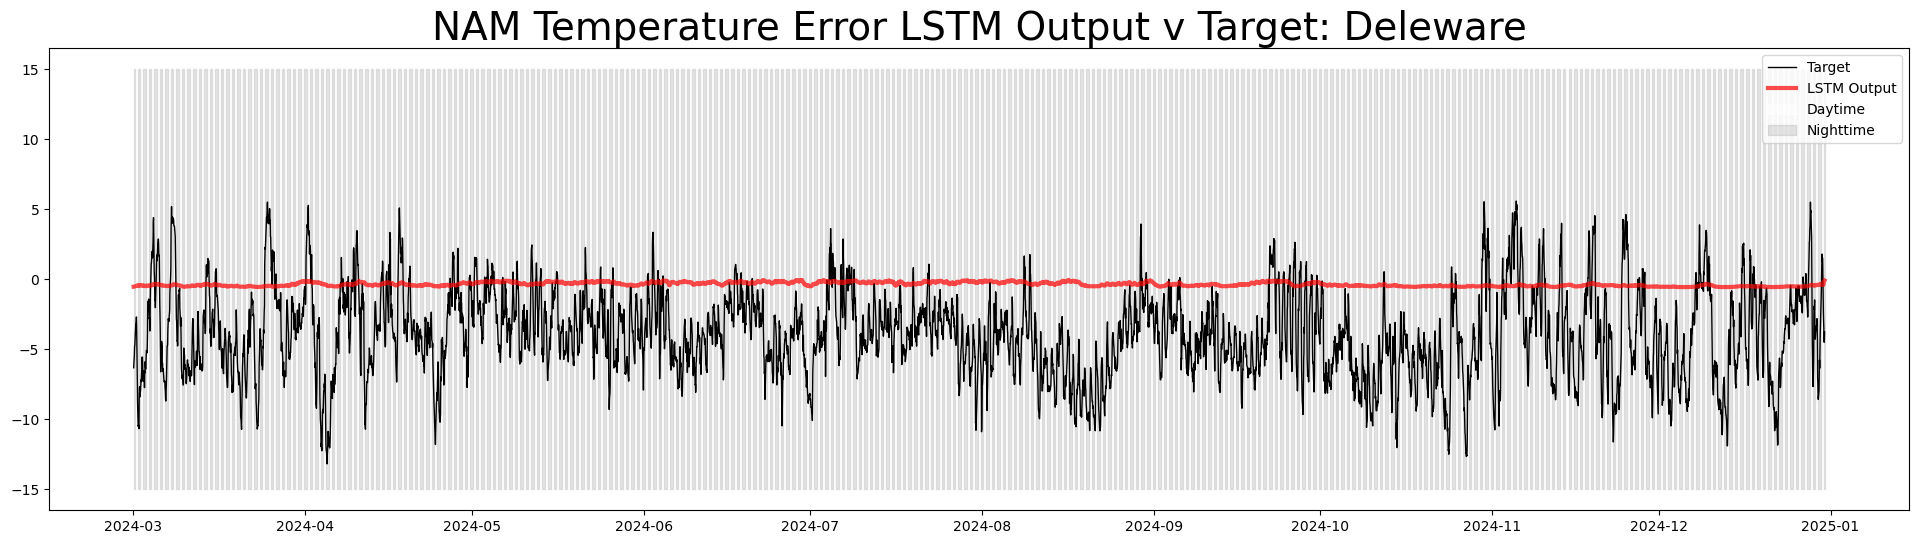

In [76]:
x = ml_output(ldf, 4, station, test_set_start, test_set_finish, -15, 15)

In [77]:
def plot_fh_drift(mae_ls, clim_divs, nwp_model, metvar):
    """
    Plots Mean Absolute Error (MAE) as a function of forecast hour (fh) for multiple climate divisions.

    Parameters:
        mae_dict (dict): Dictionary where keys are climate divisions and values are lists of MAE values.
        fh (list): Forecast hours.
        station (str): Station identifier.
        nwp_model (str): Numerical weather prediction model name.
        metvar (str): Meteorological variable.
    """
    plt.figure(figsize=(12, 7))
    fh = np.arange(1, 19)

    colors = [
        "blue",
        "green",
        "red",
        "orange",
        "darkviolet",
        "brown",
        "black",
        "gray",
        "darkcyan",
        "deeppink",
    ]  # Color palette
    for i, _ in enumerate(mae_ls):
        color = colors[i % len(colors)]  # Cycle through colors
        plt.plot(
            fh, mae_ls[i], label=clim_divs[i], marker="o", linestyle="-", color=color
        )
        plt.scatter(fh, mae_ls[i], marker="o", s=100, color=color)

        # # Annotate points
        # for j, txt in enumerate(mae_ls[i]):
        #     plt.annotate(
        #         f"{txt:.2f}",
        #         (fh[j], mae_ls[i][j]),
        #         textcoords="offset points",
        #         xytext=(0, 10),
        #         ha="center",
        #         fontsize=10,
        #         color=color,
        #     )

    # Add labels, legend, and title
    plt.xlabel("Forecast Hour (FH)", fontsize=16)
    plt.ylabel("Mean Absolute Error (MAE)", fontsize=16)
    plt.title(
        f"MAE as a Function of Forecast Hour\n{nwp_model}, {metvar}-Error",
        fontsize=18,
    )
    plt.legend(title="Climate Division", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Ensure x-ticks are integers
    plt.xticks(ticks=range(int(min(fh)), int(max(fh)) + 1), fontsize=12)
    plt.yticks(fontsize=12)
    # plt.ylim(0, 0.76)

    plt.tight_layout()

In [78]:
import seaborn as sns


def plot_mae_boxplot(wind_df_list, temp_df_list, precip_df_list, climate_divisions):
    """
    Creates a grouped boxplot where each climate division has three boxplots
    representing wind error, temperature error, and precipitation error.

    Parameters:
        wind_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for wind error.
        temp_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for temperature error.
        precip_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for precipitation error.
        climate_divisions (list of str): Names of the corresponding climate divisions.
    """
    # Create a list to store the MAE values with their associated climate division and variable type
    plot_data = []

    for clim_div, wind_df, temp_df, precip_df in zip(
        climate_divisions, wind_df_list, temp_df_list, precip_df_list
    ):
        if "mae" in wind_df.columns:
            for mae_val in wind_df["mae"]:
                plot_data.append(
                    {"Climate Division": clim_div, "MAE": mae_val, "Variable": "Wind"}
                )

        if "mae" in temp_df.columns:
            for mae_val in temp_df["mae"]:
                plot_data.append(
                    {
                        "Climate Division": clim_div,
                        "MAE": mae_val,
                        "Variable": "Temperature",
                    }
                )

        if "mae" in precip_df.columns:
            for mae_val in precip_df["mae"]:
                plot_data.append(
                    {
                        "Climate Division": clim_div,
                        "MAE": mae_val,
                        "Variable": "Precipitation",
                    }
                )

    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)

    # Create the boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        x="Climate Division", y="MAE", hue="Variable", data=plot_df, palette="Set2"
    )

    # Format the plot
    plt.xlabel("Climate Division", fontsize=14)
    plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
    plt.title(
        "MAE Distribution Across Climate Divisions for Forecast Error", fontsize=16
    )
    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.legend(title="Variable", fontsize=12, loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.savefig(
        "/home/aevans/nwp_bias/src/machine_learning/notebooks/clim_div_boxplots.png"
    )
    plt.show()

In [79]:
geo_info_df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/lstm_clusters.csv")

lulc_dict = geo_info_df.set_index("station")["lulc_cat"].to_dict()
elev_dict = geo_info_df.set_index("station")["elev_cat"].to_dict()
slope_dict = geo_info_df.set_index("station")["slope_cat"].to_dict()

In [80]:
geo_info_df.head()

,Unnamed: 0,index,station,lulc_cat,elev_cat,slope_cat
0,0,181,ADDI,1,2,0
1,1,469,ANDE,5,2,2
2,2,757,BATA,3,1,1
3,3,1045,BEAC,2,3,3
4,4,1333,BELD,5,2,3


In [81]:
def geo_map(df, lulc_dict, elev_dict, slope_dict):
    df["lulc"] = df["station"].map(lulc_dict)
    df["elev"] = df["station"].map(elev_dict)
    df["slope"] = df["station"].map(slope_dict)
    return df

In [82]:
error_path = "/home/aevans/nwp_bias/src/machine_learning/data/error_visuals"

error_dir = os.listdir(error_path)
error_dir = sorted(error_dir)

temp_master_ls = []
wind_master_ls = []
tp_master_ls = []

temp_df_ls = []
wind_df_ls = []
precip_df_ls = []

for d in error_dir:
    print(d)
    error_df1 = pd.read_parquet(f"{error_path}/{d}/{d}_tp_error_metrics_master.parquet")
    error_df2 = pd.read_parquet(
        f"{error_path}/{d}/{d}_u_total_error_metrics_master.parquet"
    )
    error_df3 = pd.read_parquet(
        f"{error_path}/{d}/{d}_t2m_error_metrics_master.parquet"
    )
    # Group by forecast hour (fh) and compute the mean MAE
    mean_mae_by_fh1 = error_df1.groupby("fh")["mae"].mean().reset_index()
    mean_mae_by_fh2 = error_df2.groupby("fh")["mae"].mean().reset_index()
    mean_mae_by_fh3 = error_df3.groupby("fh")["mae"].mean().reset_index()

    temp_df_ls.append(error_df3.reset_index())
    wind_df_ls.append(error_df2.reset_index())
    precip_df_ls.append(error_df1.reset_index())

    mae1 = mean_mae_by_fh1["mae"].values
    mae2 = mean_mae_by_fh2["mae"].values
    mae3 = mean_mae_by_fh3["mae"].values

    temp_master_ls.append(mae3)
    wind_master_ls.append(mae2)
    tp_master_ls.append(mae1)

Central Lakes
Champlain Valley
Coastal
Eastern Plateau
Great Lakes
Hudson Valley
Mohawk Valley
Northern Plateau
St. Lawrence Valley
Western Plateau


In [83]:
mae_df = pd.concat(wind_df_ls)
st.mean(mae_df["mae"])

1.1066508625865614

In [84]:
grouped = mae_df.groupby("station")["mae"].mean()

In [85]:
grouped_df = pd.DataFrame({"station": grouped.index, "mae": grouped.values})

# Add lat/lon from your station_coords dictionary
grouped_df["lat_lon"] = grouped_df["station"].map(station_coords)

In [86]:
grouped_df[["lat", "lon"]] = pd.DataFrame(
    grouped_df["lat_lon"].tolist(), index=grouped_df.index
)

In [87]:
grouped_df

,station,mae,lat_lon,lat,lon
0,ADDI,1.215981,"(42.04036, -77.23726)",42.040359,-77.237259
1,ANDE,1.192199,"(42.18227, -74.80139)",42.182270,-74.801392
2,BATA,1.596833,"(43.01994, -78.13566)",43.019939,-78.135658
3,BEAC,1.077487,"(41.52875, -73.94527)",41.528751,-73.945267
4,BELD,1.256959,"(42.22322, -75.66852)",42.223221,-75.668518
...,...,...,...,...,...
121,WFMB,0.315150,"(44.393234, -73.858826)",44.393234,-73.858826
122,WGAT,1.102798,"(43.53241, -75.1586)",43.532410,-75.158600
123,WHIT,0.884989,"(43.485073, -73.42307)",43.485073,-73.423073
124,WOLC,0.710058,"(43.22868, -76.84261)",43.228680,-76.842613


In [88]:
clim_div = [
    "St. Lawrence Valley",
    "Great Lakes",
    "Northern Plateau",
    "Champlain Valley",
    "Hudson Valley",
    "Mohawk Valley",
    "Western Plateau",
    "Eastern Pleateau",
    "Coastal",
    "Central Lakes",
]
# clim_div = sorted(clim_div)
image = "/home/aevans/nwp_bias/src/landtype/data/NCEI_logo.png"
nysm_clim = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/nysm.csv")

In [89]:
def create_xCITE_gif(grouped_df, clim_div=clim_div, nysm_clim=nysm_clim, logo=image):
    # Create your dataframe df_
    df_ = nysm_clim.copy()

    # Create plot
    fig = plt.figure(figsize=(24, 16))
    ax = fig.add_subplot(
        1,
        1,
        1,
        projection=crs.LambertConformal(
            central_longitude=-75.0, standard_parallels=(49, 77)
        ),
    )

    # Load the shapefile for boundaries
    shapefile_path = "/home/aevans/nwp_bias/src/machine_learning/notebooks/data/GIS.OFFICIAL_CLIM_DIVISIONS.shp"
    gdf = gpd.read_file(shapefile_path)

    ny_state_boundaries_path = "/home/aevans/nwp_bias/src/landtype/data/State.shx"
    ny_state_boundaries_geo = gpd.read_file(ny_state_boundaries_path).to_crs(epsg=4326)

    ny_bbox = ny_state_boundaries_geo.total_bounds
    gdf_filtered = gdf.cx[ny_bbox[0] : ny_bbox[2], ny_bbox[1] : ny_bbox[3]]
    gdf_filtered = pd.concat([gdf_filtered.iloc[20:29], gdf_filtered.iloc[[32]]])

    # Create a categorical column for plotting
    gdf_filtered["category"] = np.arange(len(gdf_filtered))

    # Plot shapefile with climate divisions (remove the automatic legend)
    gdf_filtered.plot(
        ax=ax,
        transform=crs.PlateCarree(),
        column="category",
        cmap="tab10",
        alpha=0.3,
        legend=False,
    )

    # Create legend for climate divisions using the colors from the 'tab10' colormap and labels from 'clim_div'
    division_patches = [
        mpatches.Patch(
            color=plt.cm.tab10(i / len(gdf_filtered)), alpha=0.3, label=clim_div[i]
        )
        for i in range(len(gdf_filtered))
    ]

    # Add the climate divisions legend
    legend1 = ax.legend(
        handles=division_patches,
        loc="upper right",
        title="Climate Divisions",
        fontsize=12,
    )
    ax.add_artist(legend1)  # Ensure the first legend is added to the plot

    # Set extent for the plot
    ax.set_extent([-80.0, -72.0, 40.0, 45.5], crs=crs.PlateCarree())

    # Add features
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.LAKES.with_scale("50m"), zorder=1)
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )

    # Annotate scatter points with station IDs
    for i, row in df_.iterrows():
        ax.annotate(
            row["stid"],
            (row["lon [degrees]"], row["lat [degrees]"]),
            textcoords="offset points",
            xytext=(0, 7),
            ha="center",
            fontsize=12,
            color="black",
            transform=crs.PlateCarree(),
        )

    # Plot scatter points
    sc = ax.scatter(
        grouped_df["lon"],
        grouped_df["lat"],
        s=grouped_df["mae"] * 150,
        c=grouped_df["mae"],
        cmap="viridis",
        edgecolor="black",
        transform=crs.PlateCarree(),
        zorder=10,
    )

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, pad=0.05)
    cbar.set_label("MAE", fontsize=14)

    # Add plot title
    plt.title(
        f"NCEI New York State Climate Divisions",
        fontsize=24,
    )
    # Load and add the logo to the lower left
    logo_img = mpimg.imread(logo)
    ax.figure.figimage(
        logo_img, 50, 50, zorder=20, alpha=0.5
    )  # Adjust (x, y) position as needed
    # Show plot
    plt.show()

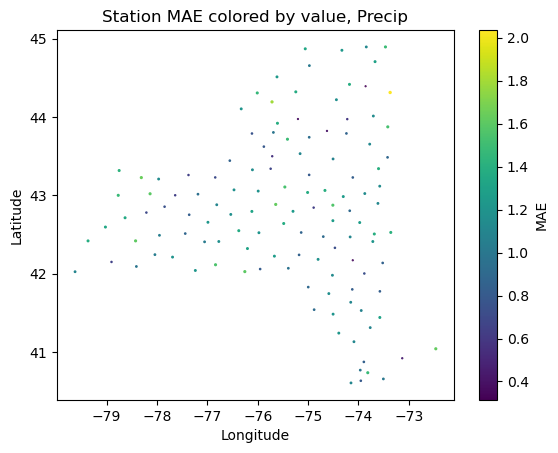

In [90]:
plt.scatter(
    grouped_df["lon"],
    grouped_df["lat"],
    s=grouped_df["mae"],
    c=grouped_df["mae"],
    cmap="viridis",
)
plt.colorbar(label="MAE")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Station MAE colored by value, Precip")
plt.show()

In [91]:
create_xCITE_gif(grouped_df)

NameError: name 'crs' is not defined

<Figure size 2400x1600 with 0 Axes>

In [ ]:
plot_fh_drift(tp_master_ls, error_dir, "HRRR", "tp")

In [ ]:
plot_mae_boxplot(temp_df_ls, wind_df_ls, precip_df_ls, error_dir)

In [ ]:
def plot_mae_boxplot_geo(wind_df_list, temp_df_list, precip_df_list, geo):
    """
    Creates a grouped boxplot where each climate division has three boxplots
    representing wind error, temperature error, and precipitation error.

    Parameters:
        wind_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for wind error.
        temp_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for temperature error.
        precip_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for precipitation error.
        climate_divisions (list of str): Names of the corresponding climate divisions.
    """
    # Create a list to store the MAE values with their associated climate division and variable type
    plot_data = []

    for clim_div, wind_df, temp_df, precip_df in zip(
        geo, wind_df_list, temp_df_list, precip_df_list
    ):
        if "mae" in wind_df.columns:
            for mae_val in wind_df["mae"]:
                plot_data.append(
                    {"Climate Division": clim_div, "MAE": mae_val, "Variable": "Wind"}
                )

        if "mae" in temp_df.columns:
            for mae_val in temp_df["mae"]:
                plot_data.append(
                    {
                        "Climate Division": clim_div,
                        "MAE": mae_val,
                        "Variable": "Temperature",
                    }
                )

        if "mae" in precip_df.columns:
            for mae_val in precip_df["mae"]:
                plot_data.append(
                    {
                        "Climate Division": clim_div,
                        "MAE": mae_val,
                        "Variable": "Precipitation",
                    }
                )

    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)

    # Create the boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        x="Climate Division", y="MAE", hue="Variable", data=plot_df, palette="Set2"
    )

    # Format the plot
    plt.xlabel("Climate Division", fontsize=14)
    plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
    plt.title(
        "MAE Distribution Across Climate Divisions for Forecast Error", fontsize=16
    )
    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.legend(title="Variable", fontsize=12, loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
error_path = "/home/aevans/nwp_bias/src/machine_learning/data/error_visuals"

error_dir = os.listdir(error_path)
error_dir = sorted(error_dir)

temp_master_ls = []
wind_master_ls = []
tp_master_ls = []

temp_df_ls = []
wind_df_ls = []
precip_df_ls = []

for d in error_dir:
    print(d)
    if d not in ["Northern Plateau"]:
        error_df1 = pd.read_parquet(
            f"{error_path}/{d}/{d}_tp_error_metrics_master.parquet"
        ).reset_index()
        error_df2 = pd.read_parquet(
            f"{error_path}/{d}/{d}_u_total_error_metrics_master.parquet"
        ).reset_index()
        error_df3 = pd.read_parquet(
            f"{error_path}/{d}/{d}_t2m_error_metrics_master.parquet"
        ).reset_index()

        error_df1 = geo_map(error_df1, lulc_dict, elev_dict, slope_dict)
        error_df2 = geo_map(error_df2, lulc_dict, elev_dict, slope_dict)
        error_df3 = geo_map(error_df3, lulc_dict, elev_dict, slope_dict)

        # Group by forecast hour (fh) and compute the mean MAE
        mean_mae_by_fh1 = error_df1.groupby("lulc")["mae"].mean().reset_index()
        mean_mae_by_fh2 = error_df2.groupby("lulc")["mae"].mean().reset_index()
        mean_mae_by_fh3 = error_df3.groupby("lulc")["mae"].mean().reset_index()

        temp_df_ls.append(error_df3.reset_index())
        wind_df_ls.append(error_df2.reset_index())
        precip_df_ls.append(error_df1.reset_index())

        mae1 = mean_mae_by_fh1["mae"].values
        mae2 = mean_mae_by_fh2["mae"].values
        mae3 = mean_mae_by_fh3["mae"].values

        temp_master_ls.append(mae3)
        wind_master_ls.append(mae2)
        tp_master_ls.append(mae1)

In [ ]:
plot_mae_boxplot_geo(
    wind_df_ls, temp_df_ls, precip_df_ls, geo_info_df["lulc_cat"].unique()
)

In [ ]:
# met_output(nysm_df, "DELE", 6)

In [ ]:
# for k in full_df.columns:
#     if re.search(
#         f"{station}|valid|Model forecast|Abs_err",
#         k,
#     ):
#         continue
#     else:
# full_df = full_df.drop(columns=[k])

In [ ]:
# test_len = int(len(full_df['valid_time'])*0.2)
# full_df = full_df.iloc[0:test_len]

In [ ]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month), (df.valid_time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(1, len(the_list) + 1)
    plt.bar(x, the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])
    ax.set_xticks(np.arange(1, len(the_list) + 1, int((len(the_list) + 1) / 6)))
    return the_list

In [ ]:
err_by_month = groupby_month(ldf, "diff")
err_by_month

In [ ]:
def groupby_time(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.hour)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))
    plt.bar(x, the_list, color="g")
    return the_list

In [ ]:
err_by_time = groupby_time(ldf, "diff")

In [ ]:
import calendar


def groupby_month_total(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))

    # Get a colormap
    cmap = plt.get_cmap("RdBu")
    # Normalize your data to map to the colormap
    norm = plt.Normalize(min(the_list), max(the_list))
    colors = cmap(norm(the_list))

    # Create a bar chart
    plt.bar(x, the_list, color=colors)
    ax.set_xticks(x)  # Set x-ticks to be at the positions of the months
    month_labels = [calendar.month_name[month] for month in GB.index]
    ax.set_xticklabels(month_labels)  # Label x-ticks with month numbers

    plt.show()
    return the_list

In [ ]:
groupby_month_total(ldf, "diff")

In [ ]:
def myround(x, base):
    return base * round(x / base)

In [ ]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [ ]:
def err_bucket(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))

    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        err = full_df["Abs_err"].iloc[i]
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]

    return temp_df, instances

In [ ]:
def plot_buckets(temp_df, instances, var_name, cmap, width):
    my_cmap = plt.get_cmap(cmap)
    averages = temp_df / instances
    y = averages
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    the_list = averages.tolist()
    fig, ax = plt.subplots(
        figsize=(21, 6), facecolor="slategrey", constrained_layout=True
    )
    bars = plt.bar(temp_df.keys(), the_list, color=my_cmap(rescale(y)), width=width)
    ax.set_title("Absolute Error of LSTM", fontsize=28, c="white")
    ax.set_xlabel(var_name, fontsize=18, c="white")
    ax.set_ylabel("Mean Absolute Error", fontsize=18, c="white")
    # Iterating over the bars one-by-one
    # Annotate each bar with its value
    # Annotate each bar with the number of instances
    for bar, value, instance_count in zip(bars, the_list, instances):
        yval = value + 0.01  # Adjust the vertical position of the label
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"n={instance_count}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
        )

In [ ]:
# for k in full_df.keys():
#     print(k)

In [ ]:
# diector = sorted(os.listdir('/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/'))

# for d in diector:
#         full_df = pd.read_parquet(
#         f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/{d}"
#     )
#         for k in full_df.columns:
#             if re.search(
#                 f"{station}",
#                 k,
#             ):
#                 print("Succes!!")
#                 print(d)
#             else:
#                 continue

In [ ]:
ldf

In [ ]:
# Reset index for both DataFrames to ensure alignment
full_df = nysm_df.copy()
full_df = full_df[full_df["station"] == "DELE"]
full_df = full_df.merge(ldf, on="valid_time")
full_df = full_df.rename(columns={"diff": "Abs_err"})
full_df = full_df[full_df["Abs_err"].abs() > 1.5]

In [ ]:
full_df.dropna(inplace=True)

In [ ]:
full_df["Abs_err"].unique()

In [ ]:
temp_df, instances = err_bucket(full_df, f"tair", 2)

In [ ]:
instances

In [ ]:
plot_buckets(temp_df, instances, "Temperature (C)", "Wistia", 2.5)

In [ ]:
relh_df, instances = err_bucket(full_df, f"relh", 2)

In [ ]:
plot_buckets(relh_df, instances, "Relative Humidity (%)", "copper", 5.0)

In [ ]:
new_df, instances = err_bucket(full_df, f"srad", 40)

In [ ]:
plot_buckets(new_df, instances, "Solar Radiation (W / m*m)", "copper", 50.0)

In [ ]:
pres_df, instances = err_bucket(full_df, f"pres", 2)

In [ ]:
print(f'The mean pressure at {station} is {full_df[f"pres"].mean()}')

In [ ]:
plot_buckets(pres_df, instances, "Surface Pressure (mb)", "copper", 1.5)

In [ ]:
def round_small(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
            temps.append(rounded)
        else:
            rounded = myround(full_df[met_col].iloc[i], 1)
            temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))
    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
        else:
            rounded = float(myround(full_df[met_col].iloc[i], base=1))
        err = float(full_df["Abs_err"].iloc[i])
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]
    temp_df = temp_df.loc[~(temp_df == 0)]
    instances = instances.loc[~(instances == 0)]
    return temp_df, instances

In [ ]:
rain_df, instances = err_bucket(full_df, f"precip_total", 0.1)

In [ ]:
plot_buckets(rain_df, instances, "Precipitation [mm/hr]", "winter", 1.0)

In [ ]:
snow_df, instances = round_small(full_df, f"snow_depth", 2)

In [ ]:
snow_df = snow_df.iloc[1:]
instances = instances.iloc[1:]

In [ ]:
plot_buckets(snow_df, instances, "Accumulated Snow (m)", "cool", 0.01)

In [ ]:
wmax, instances = err_bucket(full_df, f"wmax_sonic", 2)

In [ ]:
plot_buckets(wmax, instances, "Wind Max (m/s)", "copper", 1.0)

In [ ]:
wdir, instances = err_bucket(full_df, f"wdir_sonic", 45)

In [ ]:
plot_buckets(wdir, instances, "Wind Dir (degrees)", "copper", 10.0)